### How does the popularity of authors within a playlist affect the popularity of the playlist itself?

In [1]:
import os
import json
import pickle
from collections import defaultdict
from collections import Counter
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
with open('mappings/Q2/playlist_dataDERIVEDPOP.pkl', 'rb') as fp:
    playlist_data = pickle.load(fp)

### Total Artist Popularity vs Followers

In [3]:
tap_pop = []
for k,v in playlist_data.items():
    pop_data = v[0]
    total_pop = 0
    authors = 0
    for pop, auth in pop_data:
        total_pop += pop
        authors += auth
    followers = v[1]
    tap_pop.append([total_pop/authors, followers])
        
#     total_pop = sum([x[0] for x in pop_data])
#     authors = sum([x[1] for x in pop_data])
#     tap_pop.append((total_pop/authors, followers))

In [4]:
tap_pop[:2]

[[0.09695172090708842, 1], [94.06140227903518, 1]]

In [5]:
tap = np.array(tap_pop)

In [6]:
tap[:2]

array([[ 0.09695172,  1.        ],
       [94.06140228,  1.        ]])

In [7]:
m = [x[1] > 1 for x in tap]
tap = tap[m]

In [8]:
tap[:2]

array([[17.18216491,  2.        ],
       [61.80641015,  2.        ]])

Text(0, 0.5, 'Followers')

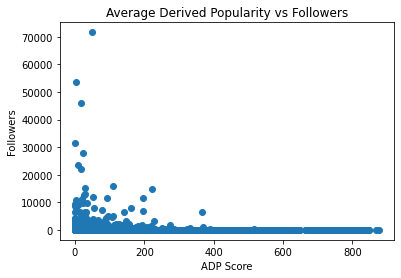

In [10]:
plt.scatter(tap[:,0], tap[:,1])
plt.title('Average Derived Popularity vs Followers')
plt.xlabel('ADP Score')
plt.ylabel('Followers')

Text(0, 0.5, 'Followers (Log Scale)')

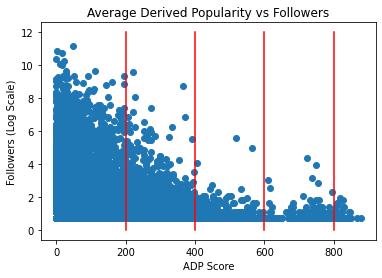

In [17]:
plt.scatter(tap[:,0], np.log(tap[:,1]))
plt.plot([200,200,200],[0,6,12], 'r-')
plt.plot([200,200,200],[0,6,12], 'r-')
plt.plot([400,400,400],[0,6,12], 'r-')
plt.plot([600,600,600],[0,6,12], 'r-')
plt.plot([800,800,800],[0,6,12], 'r-')
plt.title('Average Derived Popularity vs Followers')
plt.xlabel('ADP Score')
plt.ylabel('Followers (Log Scale)')

Text(0, 0.5, 'Number of Playlists')

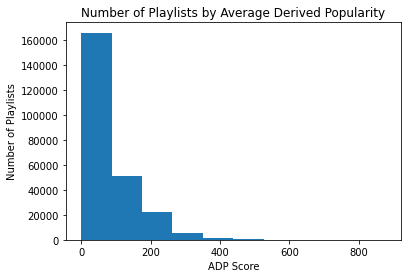

In [10]:
plt.hist(tap[:,0])
plt.title('Number of Playlists by Average Derived Popularity')
plt.xlabel('ADP Score')
plt.ylabel('Number of Playlists')

In [11]:
nbins = 5
MIN = np.min(tap[:,0])
MAX = np.max(tap[:,0])
w = (MAX-MIN)/nbins
print(MIN,MAX,w)

0.0019600861415781682 876.9777247960723 175.39515294198614


### ANOVA on TAP Score

In [12]:
def selector(a=1,b=np.max(tap[:,1]),c=0,d=np.max(tap[:,0])):
    m = [a < x[1] and x[1] <= b and c < x[0] and x[0] <= d for x in tap]
    print(len(tap[m]))
    data = tap[m]
    return data

In [13]:
bins = np.arange(MIN,MAX+w,w)
bins = list(zip(bins, bins[1:]))
groups = [selector(a=1, c=s, d=e)[:,1] for s,e in bins]

216681
27430
1411
125
133


In [14]:
for ix, s in enumerate(bins):
    a,b = s
    print('From {} to {}: {} Samples'.format(np.around(a,3), np.around(b,3), len(groups[ix])))

From 0.002 to 175.397: 216681 Samples
From 175.397 to 350.792: 27430 Samples
From 350.792 to 526.187: 1411 Samples
From 526.187 to 701.583: 125 Samples
From 701.583 to 876.978: 133 Samples


In [15]:
stat, p = stats.levene(*groups)
print(stat,p)

0.578292005148594 0.6783729138021376


In [16]:
log_groups = [np.log(g) for g in groups]
stat, p = stats.levene(*log_groups)
print(stat,p)

7.721969916583253 3.229670405672135e-06


In [24]:
stats.f_oneway(*groups)

F_onewayResult(statistic=0.578292005148594, pvalue=0.6783729138021376)

In [25]:
stats.alexandergovern(*log_groups)

AlexanderGovernResult(statistic=36.84527675807787, pvalue=1.9384653133430148e-07)

### Regressions on Buckets

In [19]:
table_arr = []
for s,e in bins:
    d = selector(a=1, c=s, d=e)
    if len(d) == 0:
        print('skipping', s, e)
        continue
    x = d[:,0]
    y = d[:,1]
    x2 = sm.add_constant(x)
    lr = sm.OLS(y, x2).fit()
    t = lr.tvalues[-1]
    p = lr.pvalues[-1]
    r, _ = stats.pearsonr(x,y)
    print(' {} to {} & {} & {} & {}'.format(np.around(s,3), 
                                            np.around(e,3),
                                            np.around(t,3),
                                            np.around(p,3),
                                            np.around(r,3)))
    table_arr.append([str(np.around(s,3)) +' to ' + str(np.around(e,3)),np.around(t,3),np.around(p,3),np.around(r,3)])
    
s = ''
for row in table_arr:
    s += ' & '.join([str(x) for x in row])
    s += '\\\ \n \hline \n'
print()
print(s)

216681
 0.002 to 175.397 & -3.411 & 0.001 & -0.007
27430
 175.397 to 350.792 & -1.045 & 0.296 & -0.006
1411
 350.792 to 526.187 & -0.893 & 0.372 & -0.024
125
 526.187 to 701.583 & -0.722 & 0.472 & -0.065
133
 701.583 to 876.978 & -2.088 & 0.039 & -0.179

0.002 to 175.397 & -3.411 & 0.001 & -0.007\\ 
 \hline 
175.397 to 350.792 & -1.045 & 0.296 & -0.006\\ 
 \hline 
350.792 to 526.187 & -0.893 & 0.372 & -0.024\\ 
 \hline 
526.187 to 701.583 & -0.722 & 0.472 & -0.065\\ 
 \hline 
701.583 to 876.978 & -2.088 & 0.039 & -0.179\\ 
 \hline 



In [20]:
table_arr = []
for s,e in bins:
    d = selector(a=1, c=s, d=e)
    if len(d) == 0:
        print('skipping', s, e)
        continue
    x = d[:,0]
    y = np.log(d[:,1])
    x2 = sm.add_constant(x)
    lr = sm.OLS(y, x2).fit()
    t = lr.tvalues[-1]
    p = lr.pvalues[-1]
    r, _ = stats.pearsonr(x,y)
    print(' {} to {} & {} & {} & {}'.format(np.around(s,3), 
                                            np.around(e,3),
                                            np.around(t,3),
                                            np.around(p,3),
                                            np.around(r,3)))
    table_arr.append([str(np.around(s,3)) +' to ' + str(np.around(e,3)),np.around(t,3),np.around(p,3),np.around(r,3)])
    
s = ''
for row in table_arr:
    s += ' & '.join([str(x) for x in row])
    s += '\\\ \n \hline \n'
print()
print(s)

216681
 0.002 to 175.397 & -13.303 & 0.0 & -0.029
27430
 175.397 to 350.792 & -3.094 & 0.002 & -0.019
1411
 350.792 to 526.187 & -2.834 & 0.005 & -0.075
125
 526.187 to 701.583 & -0.956 & 0.341 & -0.086
133
 701.583 to 876.978 & -2.195 & 0.03 & -0.188

0.002 to 175.397 & -13.303 & 0.0 & -0.029\\ 
 \hline 
175.397 to 350.792 & -3.094 & 0.002 & -0.019\\ 
 \hline 
350.792 to 526.187 & -2.834 & 0.005 & -0.075\\ 
 \hline 
526.187 to 701.583 & -0.956 & 0.341 & -0.086\\ 
 \hline 
701.583 to 876.978 & -2.195 & 0.03 & -0.188\\ 
 \hline 



### above but by conditioning on followers

In [21]:
FCUTOFF = 10

In [22]:
table_arr = []
for s,e in bins:
    d = selector(a=FCUTOFF, c=s, d=e)
    if len(d) == 0:
        print('skipping', s, e)
        continue
    x = d[:,0]
    y = d[:,1]
    x2 = sm.add_constant(x)
    lr = sm.OLS(y, x2).fit()
    t = lr.tvalues[-1]
    p = lr.pvalues[-1]
    r, _ = stats.pearsonr(x,y)
    print(' {} to {} & {} & {} & {}'.format(np.around(s,3), 
                                            np.around(e,3),
                                            np.around(t,3),
                                            np.around(p,3),
                                            np.around(r,3)))
    table_arr.append([str(np.around(s,3)) +' to ' + str(np.around(e,3)),np.around(t,3),np.around(p,3),np.around(r,3)])
    
s = ''
for row in table_arr:
    s += ' & '.join([str(x) for x in row])
    s += '\\\ \n \hline \n'
print()
print(s)

5929
 0.002 to 175.397 & -2.014 & 0.044 & -0.026
555
 175.397 to 350.792 & -1.07 & 0.285 & -0.045
20
 350.792 to 526.187 & -0.553 & 0.587 & -0.129
4
 526.187 to 701.583 & -0.381 & 0.74 & -0.26
4
 701.583 to 876.978 & -1.533 & 0.265 & -0.735

0.002 to 175.397 & -2.014 & 0.044 & -0.026\\ 
 \hline 
175.397 to 350.792 & -1.07 & 0.285 & -0.045\\ 
 \hline 
350.792 to 526.187 & -0.553 & 0.587 & -0.129\\ 
 \hline 
526.187 to 701.583 & -0.381 & 0.74 & -0.26\\ 
 \hline 
701.583 to 876.978 & -1.533 & 0.265 & -0.735\\ 
 \hline 



In [23]:
table_arr = []
for s,e in bins:
    d = selector(a=FCUTOFF, c=s, d=e)
    if len(d) == 0:
        print('skipping', s, e)
        continue
    x = d[:,0]
    y = np.log(d[:,1])
    x2 = sm.add_constant(x)
    lr = sm.OLS(y, x2).fit()
    t = lr.tvalues[-1]
    p = lr.pvalues[-1]
    r, _ = stats.pearsonr(x,y)
    print(' {} to {} & {} & {} & {}'.format(np.around(s,3), 
                                            np.around(e,3),
                                            np.around(t,3),
                                            np.around(p,3),
                                            np.around(r,3)))
    table_arr.append([str(np.around(s,3)) +' to ' + str(np.around(e,3)),np.around(t,3),np.around(p,3),np.around(r,3)])
    
s = ''
for row in table_arr:
    s += ' & '.join([str(x) for x in row])
    s += '\\\ \n \hline \n'
print()
print(s)

5929
 0.002 to 175.397 & -3.83 & 0.0 & -0.05
555
 175.397 to 350.792 & -0.049 & 0.961 & -0.002
20
 350.792 to 526.187 & 0.4 & 0.694 & 0.094
4
 526.187 to 701.583 & -0.249 & 0.826 & -0.174
4
 701.583 to 876.978 & -1.359 & 0.307 & -0.693

0.002 to 175.397 & -3.83 & 0.0 & -0.05\\ 
 \hline 
175.397 to 350.792 & -0.049 & 0.961 & -0.002\\ 
 \hline 
350.792 to 526.187 & 0.4 & 0.694 & 0.094\\ 
 \hline 
526.187 to 701.583 & -0.249 & 0.826 & -0.174\\ 
 \hline 
701.583 to 876.978 & -1.359 & 0.307 & -0.693\\ 
 \hline 

